In [15]:
import numpy as np
import control
import matplotlib.pyplot as plt

In [13]:
def Plot_state(x,dx,th,dth,t):
    fig, axs = plt.subplots(2, 2, figsize = (12,10))
    axs[0,0].plot(t, x)
    axs[0,0].set_xlabel('time')
    axs[0,0].set_ylabel('position')
    axs[0,0].set_title("Position of Cart")
    axs[0,0].grid(True)

    axs[0,1].plot(t, dx)
    axs[0,1].set_xlabel('time')
    axs[0,1].set_ylabel('velocity')
    axs[0,1].set_title("Velocity Cart")
    axs[0,1].grid(True)

    axs[1,0].plot(t, th)
    axs[1,0].set_xlabel('time')
    axs[1,0].set_ylabel('angle')
    axs[1,0].set_title("Angle of Pendulum")
    axs[1,0].grid(True)

    axs[1,1].plot(t, dth)
    axs[1,1].set_xlabel('time')
    axs[1,1].set_ylabel('omega')
    axs[1,1].set_title("Omega of Pendulum")
    axs[1,1].grid(True)

In [1]:
class Pendulum_Linear:
    def __init__(self, A,B,C,D, x0=None):
        self.Gss = control.ss(A,B,C,D)
        self.state = x0
        self.state = np.zeros((self.Gss.A.shape[0], 1)) if x0 is None else x0
        self.change_state(self.state)
        
    def change_input(self,F):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(F)
        self.output = np.array([self.y[0, 0],self.y[1,0],self.y[2,0], self.y[3,0]]) 

    def change_state(self,x):
        self.x = self.state = x
    
    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)

In [3]:
#modelling of dc motor, V as input and F as output
class Motor:
    def __init__(self, J,b,R,L,k,r):
        self.J = J
        self.b = b 
        self.R = R
        self.L = L
        self.k = k
        self.r = r
        self.Gss = self.get_Gss()
        self.state = np.array([[0],[0],[0]])
        self.change_state(self.state)
        

    def change_input(self,V):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(V)
        self.output = self.y[0,0]

    def change_state(self,x):
        self.x = self.state = x

    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)
    
    def get_Gss(self):
        A = np.array([[0,1,0],
                        [0,-self.b/self.J,self.k/self.J],
                        [0, -self.k/self.L, -self.R/self.L]])
        B = np.array([[0],[0],[1/self.L]])
        C = np.array([[0,(-self.k*self.k/(self.R*self.r)),0]])
        D = np.array([[self.k/(self.R*self.r)]])
        return control.ss(A,B,C,D)

In [6]:
# physical constants
M = 0.5;
m = 0.2;
b = 0.2;
I = 0.0034;
g = 9.8;
l = 0.3;

#motor parameter
k = 0.5 # motor torque constant
R = 6.5 # motor resistance
r = 0.05   # shaft radius
J = 0.0001
L = 0.1*10**(-6)

In [7]:
p = I*(M+m)+M*m*l**2;


A = np.array([[0   ,   1    ,          0   ,        0],
              [0 , -(I+m*l**2)*b/p , (m**2*g*l**2)/p ,  0],
              [0 ,     0         ,     0    ,       1],
              [0 , -(m*l*b)/p   ,    m*g*l*(M+m)/p , 0]])

B = np.array([[0],
          [(I+m*l**2)/p],
          [0],
          [m*l/p]])
C = np.array([[1 ,0 ,0 ,0],
              [0 ,1 ,0 ,0],
              [0 ,0 ,1 ,0],
              [0 ,0 ,0 ,1]])
D = np.array([[0],
     [0],
     [0],
     [0]])

In [8]:
pendulum = Pendulum_Linear(A,B,C,D)
motor = Motor(J=0.001,b=0.1,R=5,L=0.005,k=0.01,r=0.05)
MP_Gss = control.series(motor.Gss,pendulum.Gss)
A_mp = MP_Gss.A
B_mp = MP_Gss.B
C_mp = MP_Gss.C
D_mp = MP_Gss.D

In [9]:
class motor_pendulum:
    def __init__(self,A,B,C,D,x0 = None):
        self.n = A.shape[0]
        self.Gss= control.ss(A,B,C,D)
        self.state = np.zeros((self.n, 1)) if x0 is None else x0 
        self.change_state(self.state)

    def change_input(self,u):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(u)
        self.output = np.array([self.y[0, 0],self.y[1,0],self.y[2,0], self.y[3,0]]) 

    def change_state(self,x):
        self.x = self.state = x

    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)

In [10]:
def control_simulation_lqr(motor_pendulum):
    Q = np.array([[0., 0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 1., 0., 0., 0.],
                  [0., 0., 0., 0., 1., 0., 0.],
                  [0., 0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 0., 1.]])
    R = 1
    K, S, E = control.lqr(motor_pendulum.Gss, Q, R)

    motor_pendulum.change_input(0.0)
    
    theta = []
    position = []
    velocity = []
    omega = []
    for t in ts:
        act_state = motor_pendulum.state
        control_voltage = -np.dot(K[0],act_state).sum()
        motor_pendulum.change_input(control_voltage)
        motor_pendulum.change_state(motor_pendulum.state + motor_pendulum.derivative(control_voltage)*dt)
    
        position.append(motor_pendulum.output[0])
        velocity.append(motor_pendulum.output[1])
        theta.append(motor_pendulum.output[2])
        omega.append(motor_pendulum.output[3])
        
    return np.array([position, velocity,theta,omega])

In [11]:
ts = np.arange(0, 50, 10**(-4))
dt = ts[1]
x0 = np.array([[0.0],[0.0],[0.0],[0.0],[0.0],[0.01],[0.0]])

In [12]:
motor_pendu = motor_pendulum(A_mp,B_mp,C_mp,D_mp,x0)
x,dx,th,dth = control_simulation_lqr(motor_pendu)

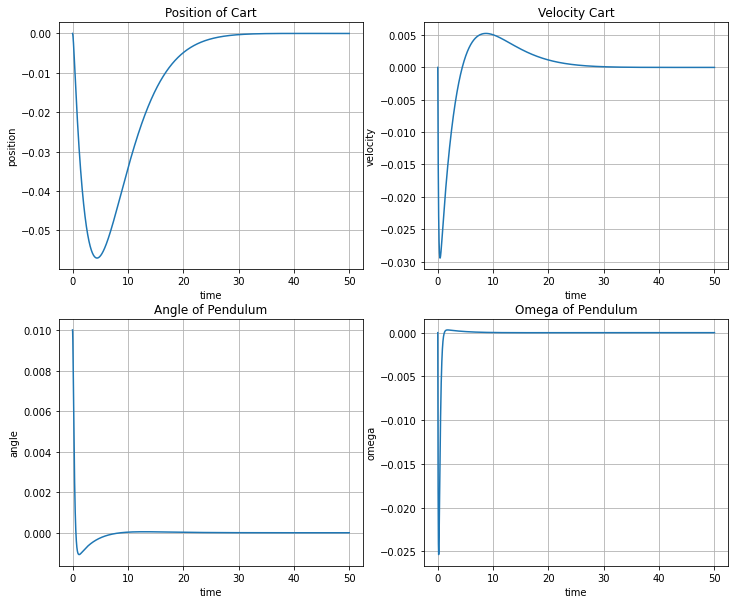

In [16]:
Plot_state(x,dx,th,dth,ts)